## Introduction

Introduction
In this notebook, we prepared the H&M fashion dataset for analysis and modeling. We cleaned the product descriptions by removing noise such as punctuation, numbers, and stopwords, and applied lemmatization to standardize the text. We also explored the structure and patterns in the data to gain insights that could support our recommendation system.

### Importing Libraries and Data

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import seaborn as sns

#import os
#import time
import re
import string

#from PIL import Image

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Parisa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Parisa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Parisa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Importing Data Frames
customers_df = pd.read_csv('../data/raw/customers.csv')
transactions_df = pd.read_csv('../data/raw/transactions_train.csv')
articles_df = pd.read_csv('../data/raw/articles.csv')

## Data Overview

In [3]:
customers_df.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...


In [4]:
transactions_df.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2


In [5]:
articles_df.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


### Initial Remarks on the DataFrames

The dataset consists of three main DataFrames: articles, customers, and transactions. These are linked through the transactions DataFrame:

    - transactions connects to articles via the article_id column.
    
    - It also links to customers via the customer_id column.

#### Articles DataFrame
The articles DataFrame contains 25 columns. Several of these appear to be redundant or duplicated — for example, both product_code and prod_name, or department_no and department_name. Depending on the type of analysis or modeling we proceed with, some of these duplicate columns can likely be dropped to simplify the dataset.

#### Transactions DataFrame
The transactions DataFrame is the largest, containing over 31 million records. For more efficient analysis and modeling, we may choose to reduce its size — for instance, by filtering based on the transaction date (t_dat) or by focusing on price-related segments.

Additionally, it may be useful to create a new units column in this DataFrame to indicate the number of items sold per transaction. This can be especially helpful when aggregating purchases by product or customer for recommendation tasks.

#### Customers DataFrame
The customers DataFrame connects users to their purchases and provides demographic and behavioral features. These may be leveraged during user profiling or for collaborative filtering approaches.

## Data Cleaning and EDA

### Articles DataFrame

In [6]:
articles_df.shape
print(f" articles_df's shape : {articles_df.shape}")

 articles_df's shape : (105542, 25)


In [7]:
articles_df.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [8]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [9]:
#Checking for NULL in articles_df:

articles_df.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

Wr’re dealing with only 416 nulls out of 105,542, which is less than ***0.4%*** of the dataset. Since the detail_desc field is crucial for our ***NLP recommender***, it’s better to drop those rows.

In [10]:
articles_df = articles_df.dropna(subset=['detail_desc'])

In [11]:
#Checking for duplicates in articles_df:

print(f'Articles Duplicated columns: {articles_df.T.duplicated().any()}')

print(f'Articles Duplicated rows: {articles_df.duplicated().any()}')

print(f'Articles Total of duplicates: {articles_df.duplicated().sum()}')

Articles Duplicated columns: False
Articles Duplicated rows: False
Articles Total of duplicates: 0


## SAVE CLEANED DATA?

In [12]:
# articles_df['cleaned_prod_name'] = articles_df['prod_name'].astype(str).apply(clean_text)
# articles_df['cleaned_detail_desc'] = articles_df['detail_desc'].astype(str).apply(clean_text)

In [13]:
# articles_df.head()

### Transactions Data Frame

In [14]:
transactions_df.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2


In [15]:
transactions_df.shape

(31788324, 5)

In [16]:
transactions_df.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [17]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [18]:
transactions_df.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

There are no null values in transaction data frame!

In [19]:
# Converting date column data to date instead of object
transactions_df['t_dat'] = pd.to_datetime(transactions_df['t_dat'])

In [20]:

transactions_df.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2


Now we are able to sort data by time if needed

In [21]:
#Checking for duplicates in transactions_df:


print(f'Transactions Duplicated rows: {transactions_df.duplicated().any()}')

print(f'Transactions Total of duplicates: {transactions_df.duplicated().sum()}')



Transactions Duplicated rows: True
Transactions Total of duplicates: 2974905


Trabsactions Data Frame has duplicate rows! to be able to handle it, we'll review the the flagged rows.

In [22]:
transactions_duplicates = transactions_df[transactions_df.duplicated(keep=False)]
transactions_duplicates.head(10)

,t_dat,customer_id,article_id,price,sales_channel_id
14,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,501820043,0.016932,2
15,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,501820043,0.016932,2
17,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,671505001,0.033881,2
18,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,671505001,0.033881,2
19,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2
20,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2
21,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2
22,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2
24,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,676827002,0.042356,2
25,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,676827002,0.042356,2


Some rows in the dataset may look like duplicates at first, but they actually represent multiple quantities of the same item being purchased in a single transaction by the same customer. 
As seen above, even though the rows are identical, they’re not mistakes — they tell us that the same item was scanned more than once or purchased in multiple units. This information is important for understanding customer behavior, basket size, and item popularity.

So to maintain data integrity and accuracy, ***we will not drop these duplicate rows***.

### Customers Data Frame

In [23]:
customers_df.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...


In [24]:
customers_df.shape

(1371980, 7)

In [25]:
customers_df.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [26]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [27]:
customers_df.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

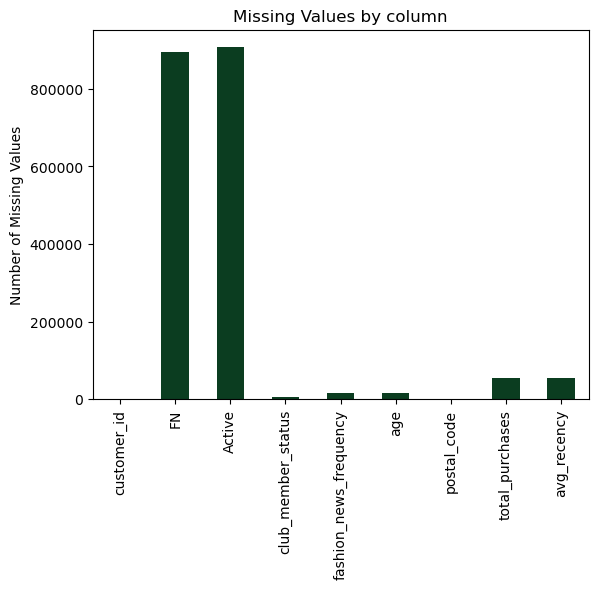

In [77]:
# Plotting Customers Missing Values:

customer_missing_values = customers_df.isna().sum()
customer_missing_values.plot(kind='bar', title='Missing Values by column', color='#0b3d20')
plt.ylabel('Number of Missing Values')
plt.show()




The customers_df contains several null values across its columns. However, since this analysis focuses only on the customer_id column — which has no missing values — we won’t be exploring the other columns with nulls in detail. The recommendation system will only use the customer_id, so the missing data in other columns won't impact our results.

In [29]:
#Checking for duplicates:

print(f'Duplicated rows: {customers_df.duplicated().any()}')

print(f'Total of duplicates: {customers_df.duplicated().sum()}')

Duplicated rows: False
Total of duplicates: 0


Our Customers DataFrame doesn't have any duplicates!

## Exploratory Data Analysis (EDA)

### Customers DataFrame EDA

In [30]:
print(f"There are {customers_df.shape[0]} rows and {transactions_df.shape[1]} columns in our transactions dataframe.\n ")

There are 1371980 rows and 5 columns in our transactions dataframe.
 


In [31]:
customers_df.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...


In [32]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [33]:
customers_df.describe().T

,count,mean,std,min,25%,50%,75%,max
FN,476930.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Active,464404.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
age,1356119.0,36.386965,14.313628,16.0,24.0,32.0,49.0,99.0


#### Let's take a look at our **Age** distribution!

In [34]:
# Calculating median, mode, and mean:

median_age = customers_df['age'].median()
mode_age = customers_df['age'].mode()[0]  # taking the first most occurring mode age
mean_age = customers_df['age'].mean()

print(f'The median age is {median_age}, the mode age is {mode_age}, and the mean age is {mean_age:.2f}.')

The median age is 32.0, the mode age is 21.0, and the mean age is 36.39.


This suggests a right-skewed distribution, where most individuals are younger, but a smaller number of older individuals raise the average age. Let’s take a closer look at the distribution in the graph below!

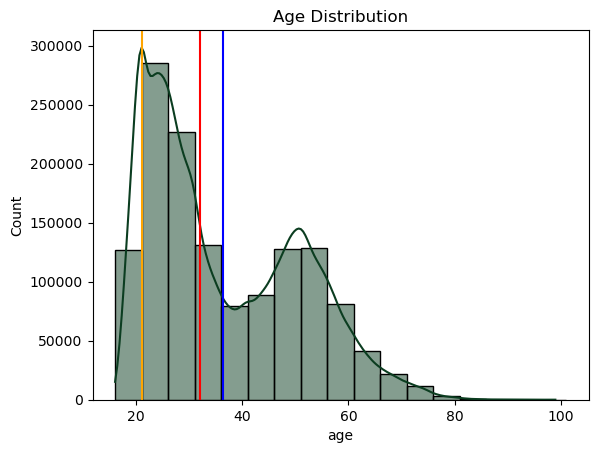

In [35]:
plt.figure()
sns.histplot(data=customers_df['age'], binwidth = 5, kde=True, color='#0b3d20')

plt.axvline(median_age, color='red', label=f'Median: {median_age}')
plt.axvline(mode_age, color='orange', label=f'Mode: {mode_age}')
plt.axvline(mean_age, color='blue', label=f'Mean: {mean_age:.2f}')

plt.title('Age Distribution')
plt.show()

Most customers are under 45 years old, with the **largest group between 20 and 30 years old**. Since the customer base is mostly young, it’s important to consider this when analyzing the data and making recommendations. This will help us create solutions that better match their needs.

#### how often customers like to receive fashion news:

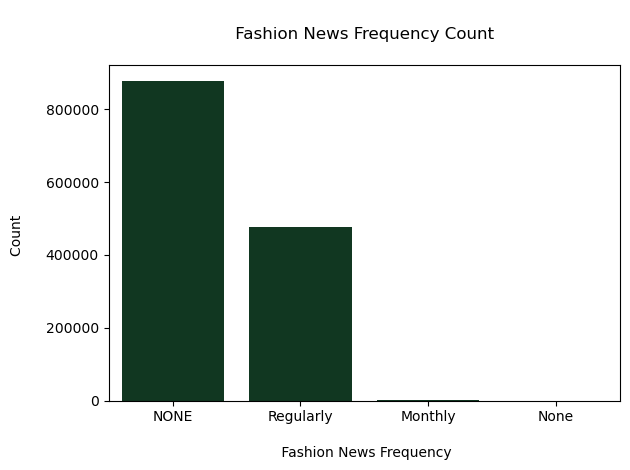

In [36]:
# Fashion News Frequency:

sns.countplot(x='fashion_news_frequency', data=customers_df, color='#0b3d20')

plt.title('\n Fashion News Frequency Count \n')
plt.xlabel('\n Fashion News Frequency')
plt.ylabel('Count \n')

plt.tight_layout()
plt.show()

The majority of customers prefer not to receive fashion news updates, while a smaller segment has opted to receive them regularly. 

#### Customers Membership Status:

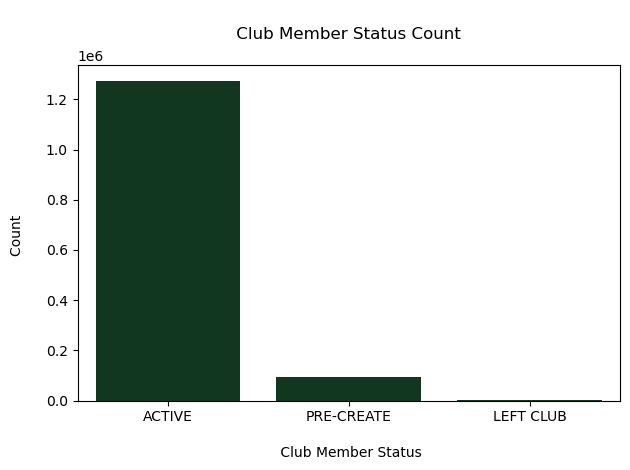

In [78]:
# Club member status count:

sns.countplot(x='club_member_status', data=customers_df, color='#0b3d20')

plt.xlabel('\n Club Member Status')
plt.ylabel('Count \n')
plt.title('\n Club Member Status Count \n')

plt.tight_layout()
plt.show()

A large portion of the dataset consists of active members in the membership program. This could be because customers who make purchases often create an account, which may automatically enroll them in the program to help track their orders. Even if they haven’t made a purchase in a while, they may still remain enrolled unless they actively choose to opt out.

### Transactions DataFrame EDA

In [38]:
print(f"There are {transactions_df.shape[0]} rows and {transactions_df.shape[1]} columns in our transactions dataframe.\n ")

There are 31788324 rows and 5 columns in our transactions dataframe.
 


We’re working with a large transaction dataset with over 31 million rows. We'll address how to manage and utilize this high-volume data as part of our recommendation strategy later in the analysis.

In [39]:
transactions_df.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2


In [40]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB


In [41]:
transactions_df.describe().T

,count,mean,std,min,25%,50%,75%,max
article_id,31788324.0,6.962272e+08,1.334480e+08,1.087750e+08,6.328030e+08,7.145820e+08,7.865240e+08,9.562170e+08
price,31788324.0,2.782927e-02,1.918113e-02,1.694915e-05,1.581356e-02,2.540678e-02,3.388136e-02,5.915254e-01
sales_channel_id,31788324.0,1.704028e+00,4.564786e-01,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


The price column in the transactions dataset appears to be normalized or scaled already. Here's why:

The prices range from ~0.000016 to ~0.59, which is much smaller than actual currency values you would expect in a retail dataset.

This likely indicates that:

    1- The prices were scaled down (e.g., divided by 100 or 1000) by H&M before sharing.

    2- The prices are represented as proportional values, possibly for privacy or uniformity reasons.

Because of this pre-scaling, we do not need to apply additional normalization or standardization at this stage. These values are ready to be used as input features directly for EDA, feature engineering, or modeling (e.g., as input to recommenders).



### Articles DataFrame EDA

In [42]:
print(f"There are {articles_df.shape[0]} rows and {articles_df.shape[1]} columns in our articles dataframe.\n ")

There are 105126 rows and 25 columns in our articles dataframe.
 


In [43]:
articles_df.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [44]:
articles_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 105126 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105126 non-null  int64 
 1   product_code                  105126 non-null  int64 
 2   prod_name                     105126 non-null  object
 3   product_type_no               105126 non-null  int64 
 4   product_type_name             105126 non-null  object
 5   product_group_name            105126 non-null  object
 6   graphical_appearance_no       105126 non-null  int64 
 7   graphical_appearance_name     105126 non-null  object
 8   colour_group_code             105126 non-null  int64 
 9   colour_group_name             105126 non-null  object
 10  perceived_colour_value_id     105126 non-null  int64 
 11  perceived_colour_value_name   105126 non-null  object
 12  perceived_colour_master_id    105126 non-null  int64 
 13 

In [45]:
product_group_counts = articles_df['product_group_name'].value_counts()
product_group_counts

Garment Upper body       42593
Garment Lower body       19763
Garment Full body        13245
Accessories              11141
Underwear                 5449
Shoes                     5196
Swimwear                  3104
Socks & Tights            2438
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

In [46]:
selected_product_group = product_group_counts[product_group_counts > 9].index
selected_product_group
articles_df = articles_df[articles_df["product_group_name"].isin(selected_product_group)]
articles_df["product_group_name"].value_counts()

Garment Upper body     42593
Garment Lower body     19763
Garment Full body      13245
Accessories            11141
Underwear               5449
Shoes                   5196
Swimwear                3104
Socks & Tights          2438
Nightwear               1899
Unknown                  121
Underwear/nightwear       54
Cosmetic                  49
Bags                      25
Items                     17
Furniture                 13
Name: product_group_name, dtype: int64

The distribution of product_group_name in the articles dataset shows some categories had fewer than 9 items ("Fun", "Stationery", "Interior textile"), which are either out of scope for a fashion recommender or too rare to extract meaningful patterns. To reduce noise and improve model quality, we removed these rare product groups.

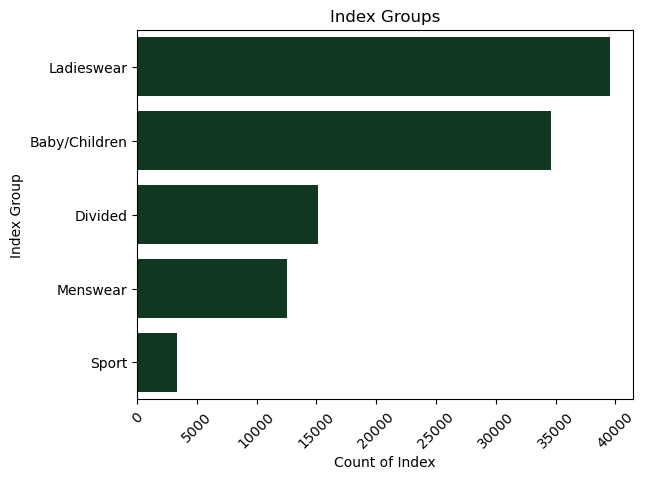

In [47]:
index_group_name_counts = articles_df['index_group_name'].value_counts()

plt.figure()
sns.barplot(x=index_group_name_counts, y=index_group_name_counts.index,color='#0b3d20')

plt.xticks(rotation=45)
plt.xlabel("Count of Index")
plt.ylabel("Index Group")
plt.title("Index Groups")

plt.show()

In [48]:
articles_df["product_type_name"].value_counts().tail(20)

Backpack                  6
Straw hat                 6
Sleep Bag                 6
Alice band                6
Cross-body bag            5
Mobile case               4
Moccasins                 4
Chem. cosmetics           3
Baby Bib                  3
Braces                    3
Tote bag                  2
Eyeglasses                2
Wireless earphone case    2
Hairband                  2
Shoulder bag              2
Headband                  1
Pre-walkers               1
Bumbag                    1
Bra extender              1
Keychain                  1
Name: product_type_name, dtype: int64

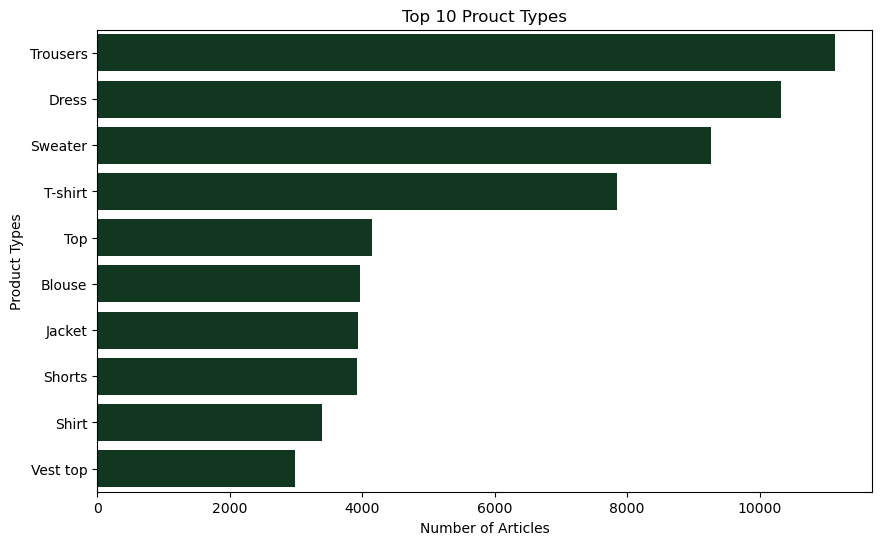

In [49]:
top_10_products = articles_df['product_type_name'].value_counts().head(10)


plt.figure(figsize=(10,6))
sns.barplot(x=top_10_products.values, y=top_10_products.index,color='#0b3d20')

# plt.xticks(rotation=90)
plt.xlabel("Number of Articles")
plt.ylabel("Product Types")
plt.title("Top 10 Prouct Types")
plt.show()

We examined the most common product types in the dataset. The top 10 most frequent items include essential wardrobe staples such as trousers, dresses, sweaters, and T-shirts. These categories dominate the dataset, with trousers being the most represented, followed by dresses and sweaters.

This distribution suggests that H&M’s product offerings are heavily focused on casual and core apparel, which may influence customer purchase behavior and should be considered in the recommendation logic.

<!-- Since these product types are well-represented, they provide a solid foundation for both collaborative filtering models (due to their frequency) and content-based approaches (with ample data to extract features from descriptions, prices, or style details). -->

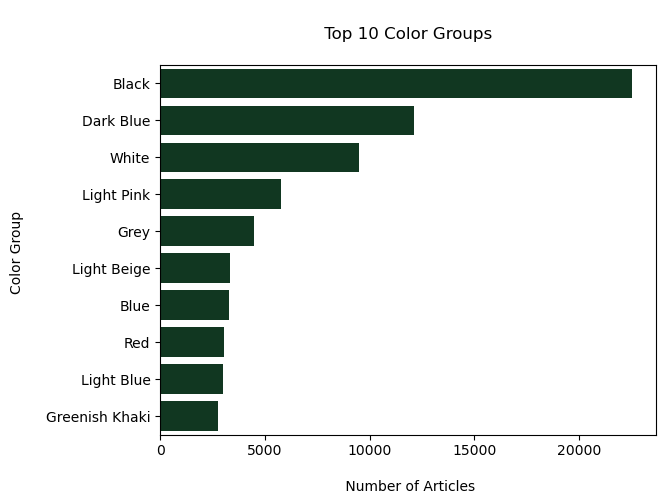

In [50]:
# Top 10 Articles by Color Group:

color_group_counts = articles_df['colour_group_name'].value_counts().head(10)
sns.barplot(x=color_group_counts.values, y=color_group_counts.index,color='#0b3d20')

plt.title('\n Top 10 Color Groups \n')
plt.xlabel('\n Number of Articles')
plt.ylabel('Color Group \n')
plt.show()


In [51]:
articles_df['detail_desc'].value_counts().head(10)

T-shirt in printed cotton jersey.                                                      159
Leggings in soft organic cotton jersey with an elasticated waist.                      138
T-shirt in soft, printed cotton jersey.                                                137
Socks in a soft, jacquard-knit cotton blend with elasticated tops.                     136
Fine-knit trainer socks in a soft cotton blend with elasticated tops.                  134
Socks in a soft, fine-knit cotton blend with elasticated tops.                         118
Sunglasses with plastic frames and UV-protective, tinted lenses.                       117
Boxer shorts in a cotton weave with an elasticated waist, long legs and button fly.    104
Tights in a soft, fine-knit cotton blend with an elasticated waist.                     97
Fine-knit socks in a soft cotton blend.                                                 97
Name: detail_desc, dtype: int64

In [75]:
# Adjust display to show full description text
pd.set_option('display.max_colwidth', None)

unique_descriptions = articles_df['detail_desc'].unique()

print(f"Total unique description: {len(unique_descriptions)}")

unique_descriptions_series = pd.Series(unique_descriptions)
sample_description = unique_descriptions_series.sample(5, random_state=42)
for i, desc in enumerate(sample_description, 1):
    print(f"{i},{desc}\n")

Total unique description: 43391
1,Pile-lined jacket in imitation suede with a pile-lined stand-up collar with a fastening. Zip down the front and open front pockets.

2,Jacket in Tencel™ lyocell twill with rounded lapels, a drawstring at the waist, a concealed press-stud fastening at the front and long sleeves. Unlined.

3,Fitted vest top in ribbed jersey in a narrow cut at the top.

4,Short sports tights in fast-drying functional fabric with a wide waistband to hold in and shape the waist. Concealed key pocket in the waistband.

5,Top in sweatshirt fabric with a lined drawstring hood, and text print on the front. Long sleeves, a kangaroo pocket, and ribbing at the cuffs and hem. Soft brushed inside.



Since our NLP recommender system will rely heavily on product descriptions, it’s important to explore and clean the detail_desc column to ensure high-quality input for embeddings and downstream tasks.

In [53]:
articles_df['desc_length'] = articles_df['detail_desc'].str.len()
articles_df['desc_length'].describe()

count    105107.000000
mean        142.137879
std          68.059697
min          11.000000
25%          94.000000
50%         132.000000
75%         178.000000
max         764.000000
Name: desc_length, dtype: float64

The average description is about 142 characters long, which is reasonable for capturing useful product information.

The shortest description is just 11 characters, and the longest is 764 characters.

Most descriptions (50%) are between 94 and 178 characters long.

A few descriptions are quite short (under 20), which might lack enough context for semantic comparison.

In [54]:
# Initialize the stopwords list:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Creating custom tokenizer function:

def text_cleaner(text):

    if not isinstance(text, str):

        return ""
    
    # Lowercasing
    text = text.lower()

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
     
    # Splitting into words
    words = text.split()

    #
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]

    # Removing stopwords
    words = [word for word in words if word not in stop_words and word]

    # Reconstructing the sentence
    cleaned_text = ' '.join(words)

    return cleaned_text



In [55]:
# Apply to dataset
articles_df['preprocessed_desc'] = articles_df['detail_desc'].apply(text_cleaner)


In [56]:
from sklearn.feature_extraction.text import CountVectorizer

green_palette = [
    "#0b3d20",  # very dark forest green
    "#14532d",  # deep pine green
    "#1e4620",  # moss green
    "#2e5939",  # muted ivy
    "#3b6b4d",  # sage pine
    "#497f5e",  # soft fern
    "#5c8a64",  # eucalyptus
    "#70996e",  # faded olive
    "#7fa179",  # green clay
    "#8fad87",  # sage
    "#9bbd94",  # dusty mint
    "#adcbaa",  # light muted green
]

def plot_top_ngrams(text_series, title, ngram_range=(1, 1), top_n=10):
    
    # Initiate
    bagofwords = CountVectorizer(
        
        ngram_range=ngram_range)
    
    # Fit and Transform
    transformed = bagofwords.fit_transform(text_series.tolist())
    
    transactions_df = pd.DataFrame( data=transformed.toarray(),columns=bagofwords.get_feature_names_out())
    word_counts = transactions_df.sum(axis=0).sort_values(ascending=False)

    #Select top-n ngrams and their counts
    top_ngrams = word_counts.head(top_n)
    words = top_ngrams.index.tolist()
    counts = top_ngrams.values
    
    plt.figure(figsize=(7,4))
    sns.barplot(x=counts, y=words, palette=nude_palette)
    plt.xlabel("Frequency\n")
    plt.ylabel(f"Top {top_n} {ngram_range[0]}-grams")
    if ngram_range == (1,1):
        plt.title(f"Most Common Unigrams in {title} Descriptions")
    
    else:
        plt.title(f"Most Common {ngram_range}-grams in {title} Descriptions")
    plt.tight_layout()
    plt.show()



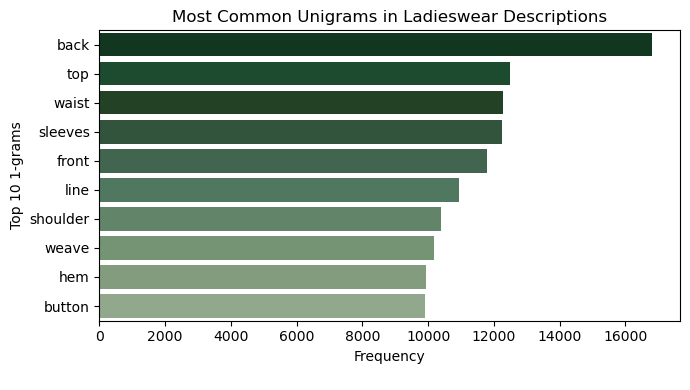

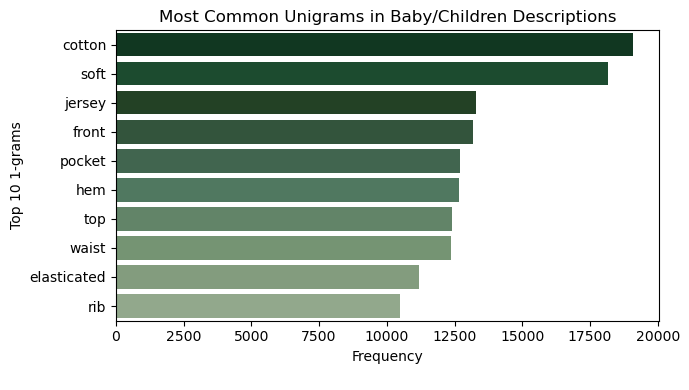

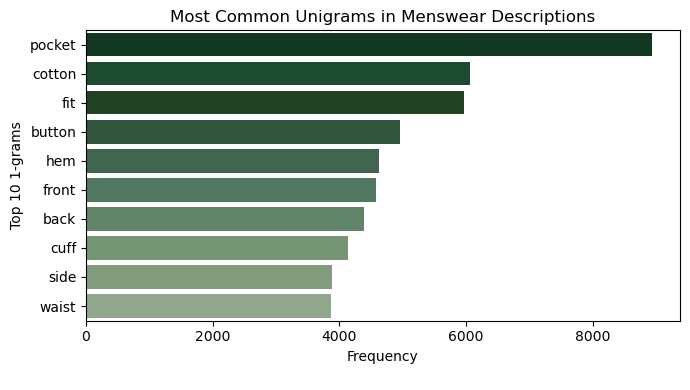

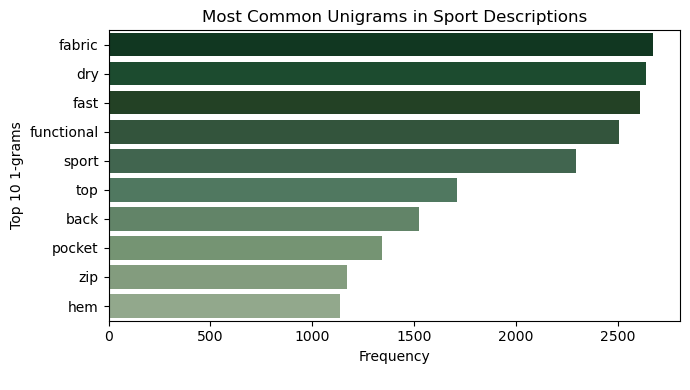

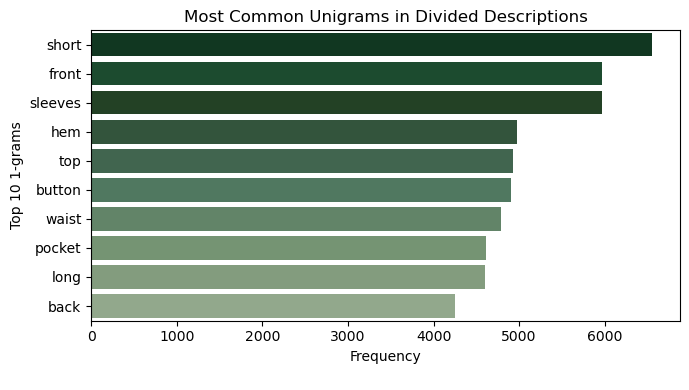

In [57]:
for group in articles_df['index_group_name'].unique():
    group_desc = articles_df[articles_df['index_group_name'] == group]['preprocessed_desc']
    plot_top_ngrams(group_desc, group, ngram_range=(1, 1), top_n=10)
    

The bar charts above showcase the most frequently used words in product descriptions across different index groups. Words like "back," "top," and "cotton" are commonly found, indicating a focus on particular garment features and materials. Each index group highlights different priorities—for example, Baby/Children’s wear emphasizes comfort, while the Sport category focuses more on performance.



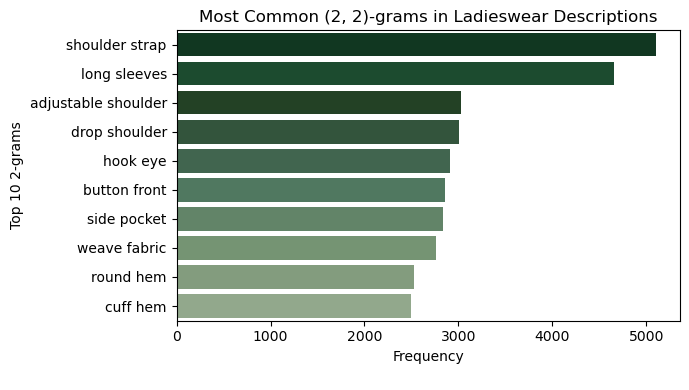

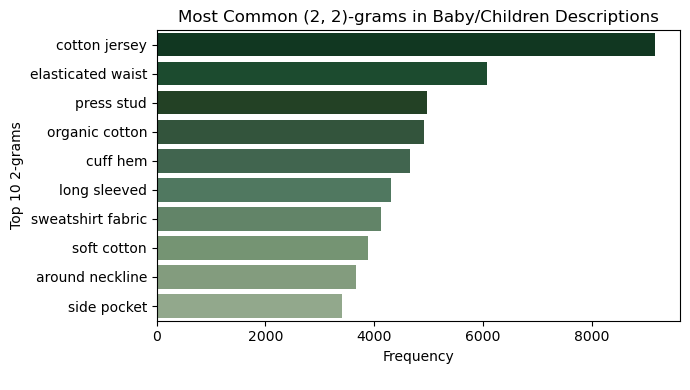

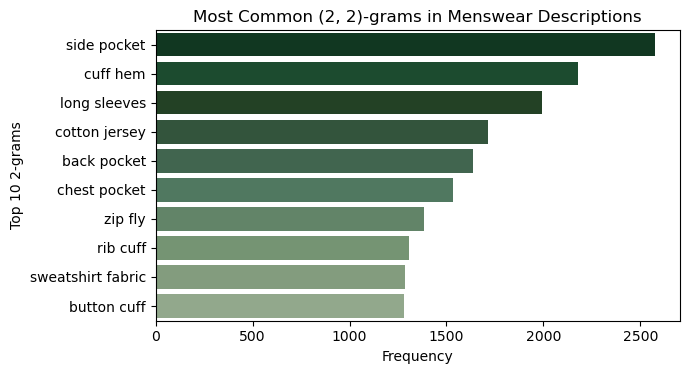

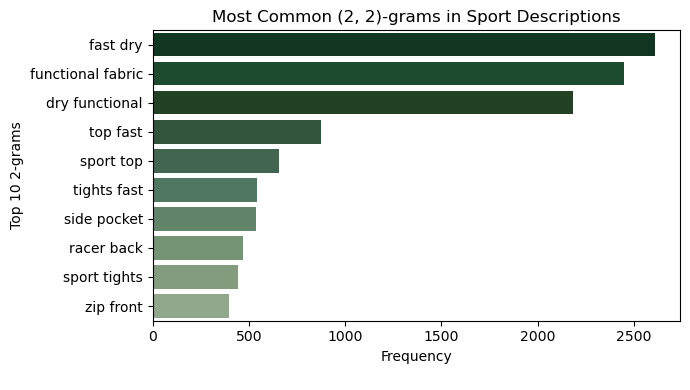

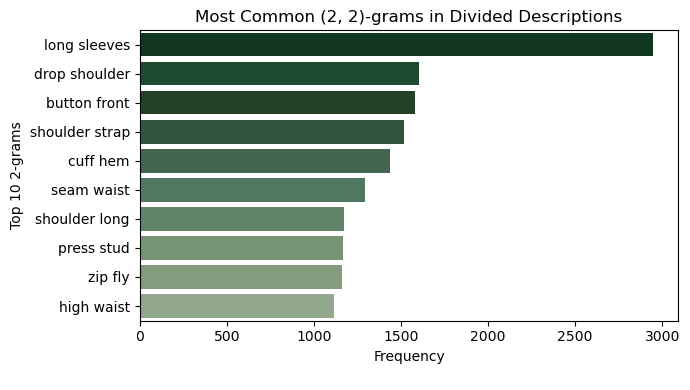

In [58]:
for group in articles_df['index_group_name'].unique():
    group_desc = articles_df[articles_df['index_group_name'] == group]['preprocessed_desc']
    plot_top_ngrams(group_desc, group, ngram_range=(2, 2), top_n=10)

Byy analyzing bigrams instead of unigrams, we sometimes gain more meaningful insights. For example, "long sleeves" provides clearer context than just "sleeves," and phrases like "shoulder strap" or "drop shoulder" are more informative than the single word "shoulder." This highlights the importance of examining bigrams to better understand the specific features mentioned in product descriptions.

## Feature Engineering

Now, let's add a few features that might help later in the modeling:

#### Add Features to transactions DataFarme

To better understand customer purchasing behavior over time, we extracted additional time-based features from the transaction dates:

    Week: ISO calendar week of the transaction.

    Month: Calendar month of the transaction.

    Day of the week: From 0 (Monday) to 6 (Sunday).

We also created a season column based on the month to categorize transactions into Winter, Spring, Summer, and Fall. This will help us analyze seasonal trends and identify patterns in customer activity across different times of the year.

In [59]:
transactions_df['week'] = transactions_df['t_dat'].dt.isocalendar().week
transactions_df['month'] = transactions_df['t_dat'].dt.month
transactions_df['dayofweek'] = transactions_df['t_dat'].dt.dayofweek

#Create a season column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

transactions_df['season'] = transactions_df['month'].apply(get_season)


In [60]:
# Get the latest transaction date
latest_date = transactions_df['t_dat'].max()
transactions_df['recency'] = (latest_date - transactions_df['t_dat']).dt.days

# Check the top 5 recency values
transactions_df[['customer_id', 'recency']].head(5)

,customer_id,recency
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,733
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,733
2,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,733
3,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,733
4,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,733


In [61]:
latest_date = transactions_df['t_dat'].max()
earliest_date = transactions_df['t_dat'].min()

print(f"The latest transaction date is {latest_date}\n")
print(f"The earliest transaction date is {earliest_date}\n")

The latest transaction date is 2020-09-22 00:00:00

The earliest transaction date is 2018-09-20 00:00:00



To manage the large size of our transactions_df (which contains over 31 million transactions), the analysis will be focused on the most recent data (3months). This approach ensures that the analysis is both manageable and focused on the most recent and relevant data.


In [62]:
# Getting the maximum date in the 't_dat' column and calculating the start date as 2 weeks before the end date: 

start_date = latest_date - pd.DateOffset(weeks=12)

# Filtering the dataframe to include only the last 2 weeks of data:

transactions_df = transactions_df[transactions_df['recency'] >= 60]

# Printing the shape of the filtered dataframe:

print(f"transactions dataframe shape is:{transactions_df.shape}\n")
print(f"count of transactions unique article_id is:{transactions_df['article_id'].nunique()}")

transactions dataframe shape is:(29452820, 10)

count of transactions unique article_id is:97805


#### Add Feauters in Customers DataFrame

We added two useful features to the customer dataset to better understand shopping behavior:

    Total Purchases: The number of times each customer made a purchase, based on how many transactions they have.

    Average Recency: The average number of days between each customer's purchases, which helps us understand how often they shop.

These features were merged into the customers_df to give us a more complete view of customer activity and help with future analysis and recommendations.

In [63]:
# Total purchase by customer
customer_purchases = transactions_df.groupby('customer_id')['article_id'].count().reset_index()
customer_purchases.columns = ['customer_id', 'total_purchases']

customers_df = pd.merge(customers_df, customer_purchases, on='customer_id', how='left')

#Average Recency per Customer
average_recency = transactions_df.groupby('customer_id')['recency'].mean().reset_index()
average_recency.columns = ['customer_id', 'avg_recency']

customers_df = pd.merge(customers_df, average_recency, on='customer_id', how='left')
customers_df[['customer_id', 'avg_recency', 'total_purchases']].head(2)

,customer_id,avg_recency,total_purchases
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,372.65000,20.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,385.27907,86.0


#### Add features to Articles DataFrame

We calculated how popular each article is by counting how many times it was purchased across all transactions. This gives us a popularity score for each article.

We then merged this information into the articles_df, so each item now includes a popularity metric. This can help us identify bestsellers and understand customer preferences.



In [64]:
# Total transactions per article
article_popularity = transactions_df.groupby('article_id')['customer_id'].count().reset_index()
article_popularity.columns = ['article_id', 'popularity']

# Merge with articles
articles_df = pd.merge(articles_df, article_popularity, on='article_id', how='left')

In [65]:
articles_df['popularity'] = articles_df['popularity'].fillna(0)
articles_df[['article_id', 'popularity']].head(2)


,article_id,popularity
0,108775015,10841.0
1,108775044,7212.0


In [66]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105107 entries, 0 to 105106
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   article_id                    105107 non-null  int64  
 1   product_code                  105107 non-null  int64  
 2   prod_name                     105107 non-null  object 
 3   product_type_no               105107 non-null  int64  
 4   product_type_name             105107 non-null  object 
 5   product_group_name            105107 non-null  object 
 6   graphical_appearance_no       105107 non-null  int64  
 7   graphical_appearance_name     105107 non-null  object 
 8   colour_group_code             105107 non-null  int64  
 9   colour_group_name             105107 non-null  object 
 10  perceived_colour_value_id     105107 non-null  int64  
 11  perceived_colour_value_name   105107 non-null  object 
 12  perceived_colour_master_id    105107 non-nul

### Exporting Cleaned Data

In [73]:
articles_df.to_csv("../data/processed/cleaned_articles.csv", index=False)
customers_df.to_csv("../data/processed/cleaned_customers.csv", index=False)
transactions_df.to_csv("../data/processed/cleaned_transactions.csv", index=False)


In [74]:
articles_df.to_pickle("../data/processed/cleaned_articles.pkl")
customers_df.to_pickle("../data/processed/cleaned_customers.pkl")
transactions_df.to_pickle("../data/processed/cleaned_transactions.pkl")


### Conclusion

We successfully cleaned and standardized over 100,000 product descriptions,over  removing duplicates and missing values to ensure high data quality. Key themes across product groups were identified through visualization, and the data was thoroughly prepared for embedding and modeling by maintaining consistency throughout.